<a href="https://colab.research.google.com/github/mahmoudiwalid/dema.image_classification/blob/main/Image_Binary_Classification_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#This is "mounting"--plopping the drive into your file system, giving the the file an access location


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Installation du modul tensorflow
!pip install tensorflow

In [5]:
import tensorflow as tf #import the module tensorflow
from tensorflow import keras #import the keras model
from tensorflow.keras import layers #import the layers 

In [6]:
#download the dtata
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
#curl stads for "client url" it is a tool for transferring data requests to and from a server - in this case a cloud server
#-O will save the file in the current working directory with the same file name as remote
#-o lets you specify a different file name or location

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   188M      0  0:00:04  0:00:04 --:--:--  188M


In [7]:
# should ask Assan what is the utility of ! 
# the file is named kagglecatsanddogs_3367a.zip, it is zip file, it is located in the sample_data folder.
!ls


drive  kagglecatsanddogs_3367a.zip  sample_data


In [8]:
# what is inside sample data, Just I wnat to know it is out of the scope of this notebook
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [9]:
#unzip the file, what does -q do ?
!unzip -q kagglecatsanddogs_3367a.zip

In [10]:
#list what is in this unzipped file
!ls

 drive			      'MSR-LA - 3467.docx'  'readme[1].txt'
 kagglecatsanddogs_3367a.zip   PetImages	     sample_data


In [11]:
# the data set is now in the folder PetImages

In [12]:
#list what is inside the PetImage folder 
!ls PetImages

Cat  Dog


In [13]:
#list what is inside Cat file
!ls PetImages/Cat

0.jpg	   11608.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10000.jpg  11609.jpg  1967.jpg	3574.jpg  5181.jpg  678.jpg   8397.jpg
10001.jpg  1160.jpg   1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10002.jpg  11610.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10003.jpg  11611.jpg  196.jpg	3577.jpg  5184.jpg  6792.jpg  839.jpg
10004.jpg  11612.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  83.jpg
10005.jpg  11613.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10006.jpg  11614.jpg  1972.jpg	357.jpg   5187.jpg  6795.jpg  8401.jpg
10007.jpg  11615.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10008.jpg  11616.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jpg
10009.jpg  11617.jpg  1975.jpg	3582.jpg  518.jpg   6798.jpg  8404.jpg
1000.jpg   11618.jpg  1976.jpg	3583.jpg  5190.jpg  6799.jpg  8405.jpg
10010.jpg  11619.jpg  1977.jpg	3584.jpg  5191.jpg  679.jpg   8406.jpg
10011.jpg  1161.jpg   1978.jpg	3585.jpg  5192.jpg  67.jpg    8407.jpg
10012.jpg  11620.jpg  1979

#Filter out corrupted images

In [14]:
import os #this is ti ineract the operating system
# this to handle paths and directories

num_skipped = 0
for folder_name in ("Cat", "Dog"): #remember Cat Dog are both folder contaning the images dataset
    folder_path = os.path.join("PetImages", folder_name) # join and produce a full path we will have 2 paths like this either "PetImage/Cat" and "PetImage/Dog" 
    for fname in os.listdir(folder_path): # to get the list of all files in the folder path
        fpath = os.path.join(folder_path, fname) # the final path a final image
        try: # test a block of code for errors
            fobj = open(fpath, "rb") #the "rb" mode opens the file in binary format for reading, 
            #while the "wb" mode opens the file in binary format for writing
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # tf.compat.as_bytes: tensortflow onverts bytearray, bytes, or unicode 
            #python input types to bytes. in our case it converts "JFIF" in bytes
            # fobj.peek : checks if it is present in the file object, at byte 10. It's a quick that verifies content of a header ??

        finally: #will be executed regardless if the try block raises an error or not
            fobj.close()

        if not is_jfif:
            num_skipped += 1 # count the number image that are not JFIF, increment by one each time it is not JFIF 
            os.remove(fpath)# delate corrupted image, the not JFIF images

print("Deleted %d images" % num_skipped)# pritn the number of skipped /removed images

Deleted 1590 images


#Generate the dataset

In [15]:
image_size = (180, 180) #fixe the size of the image at 180 x 180 pixel
batch_size = 32 # each training iteration takes 32 image: the 1st iteration = the 1st 32 image, the 2n iter = the 2nd 32 image and so on..

train_ds = tf.keras.preprocessing.image_dataset_from_directory( # the keras model to process the image
    "PetImages", # the target directory, I think in this step tf.keras can have acess to the folders inside PetImages, the two Cat and Dog folders,
    #it will not stop in PetImages folder
    validation_split=0.2, # validation is 20 % of the data
    subset="training", # this is the trainig data set
    seed=1337, # Optional random seed for shuffling and transformations, 
    #This is not a tensorflow specific term, in fact almost any programming language have a seed for
    #random generators, with a seed you make sure that you can reproduce your results when using
    #random generators(using the same seed two times, would result in the same random number).
    # mean we should use the same seed for validation and trainig in order to avoid image redendancy
    image_size=image_size, # image size is pre-fixed (180 x 180) pixel
    batch_size=batch_size, # pr-defined at 32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation", # this is the validation data set
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


#Data visualization

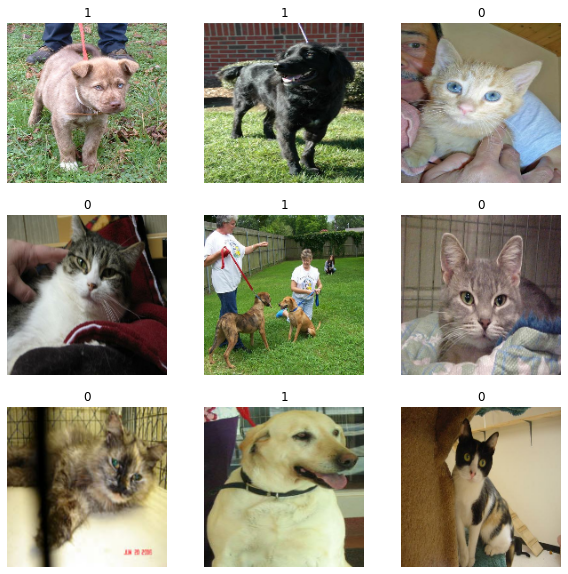

In [16]:
import matplotlib.pyplot as plt # this is for plotting, calling plot from pyplot 
#will automatically create the necessary figure and axes to achieve the desired plot

plt.figure(figsize=(10, 10)) #Create a new figure, or activate an existing figure.
# in our case we will activate existing figure and size it 10 pixel width x 10 pixel height
# see the following: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
for images, labels in train_ds.take(1): # start with taking 1 element of the data set, and for this element returns a tuple (data, label)
    for i in range(9): # iterate over the first 9 element of training dataset
        ax = plt.subplot(3, 3, i + 1) # display 3 images x 3 images (3 rows x 3 columns) with index i+1 ==> index from 1 to 9
        # why i+1 : because range(9) will give numbers from 0 to 8 and we want it ("the index") to be from 1 to 9
        plt.imshow(images[i].numpy().astype("uint8")) #display image that should be converted to unit8 --> [0,255] pixel
        #Python, by default, uses image data in the form of a NumPy array: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
        #https://www.analyticsvidhya.com/blog/2021/03/grayscale-and-rgb-format-for-storing-images/
        plt.title(int(labels[i]))# Set a title for the axes. int: because the default library (matplotlib.pyplot.title(label,
         # fontdict=None, loc='center', pad=None, **kwargs)) label is set by default "str" so we want to convert it to int
        plt.axis("off")# remoce x and y axis form the plot

#Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [17]:
data_augmentation = keras.Sequential( # Sequential model is a linear stack of layers
    [
        layers.RandomFlip("horizontal"), #randomly flip the data horizontally
        layers.RandomRotation(0.1), # randomly rotate the data , 0.1 is the foactor rotation it a fraction of 2pi
     #0.1 ==> factor = 0.1 * 2pi
     # positive factor mean rotation counter clock wise
     # https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

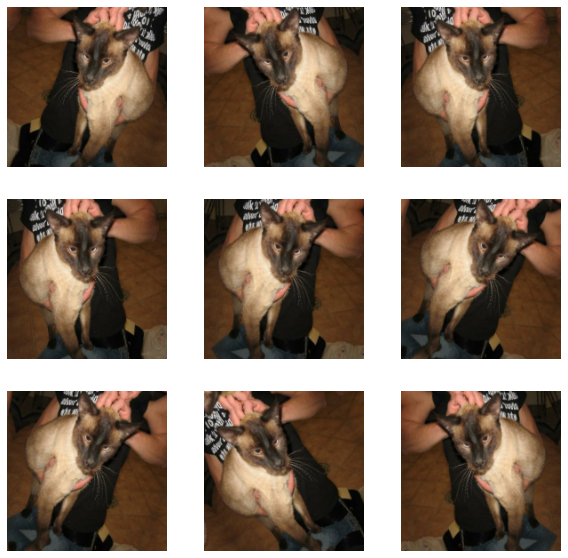

In [18]:
plt.figure(figsize=(10, 10)) # create afigure or activate an existing figure 10 pixel high x 10 pixel width
for images, _ in train_ds.take(1): # the "_" : The python interpreter stores the last expression value to the special variable called _
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # plot the1st image 
        plt.axis("off")

#Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

##Two options to preprocess the data
There are two ways you could be using the data_augmentation preprocessor:

Option 1: Make it part of the model, like this:

In [19]:
#inputs = keras.Input(shape = input_shape) ==> in our case shape = (180, 180)
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)


##Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

In [24]:
#augmented_train_ds = train_ds.map(
  #lambda x, y: (data_augmentation(x, training=True), y))

#Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

Prefetching: https://en.ryte.com/wiki/Prefetching

In [20]:
train_ds = train_ds.prefetch(buffer_size=32) #used to separate the time when data is produced (output) from
# the time when data is consumed (input)
val_ds = val_ds.prefetch(buffer_size=32)

#Build a model

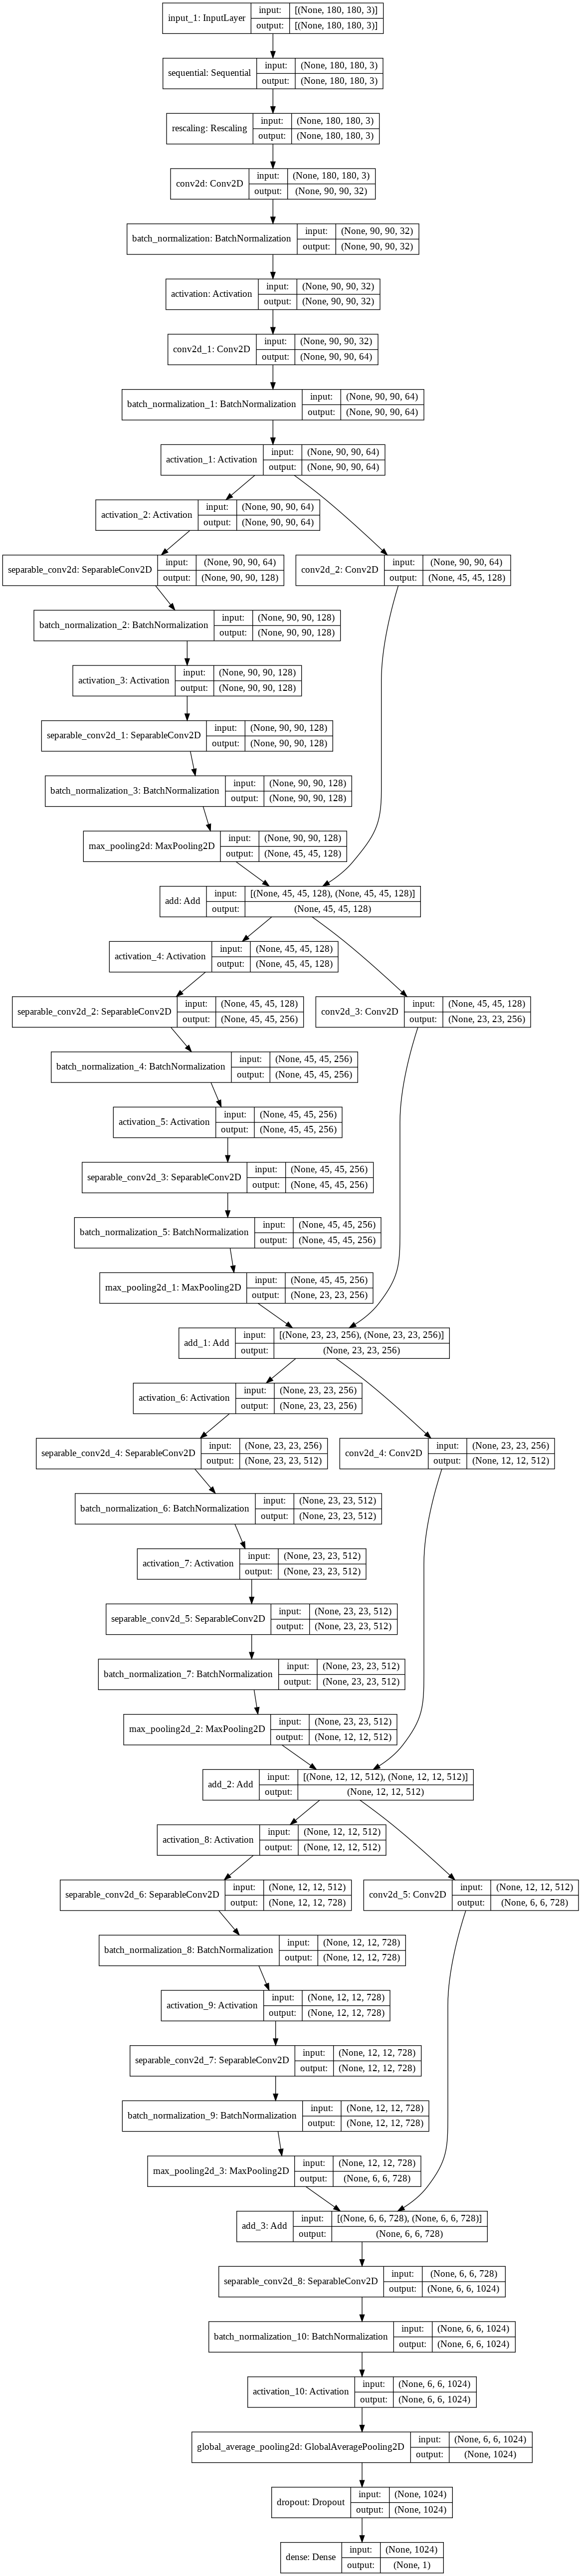

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # standardize values to be in the [0, 1]
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) #2D convolution layer: #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
    #32: filters --> numbers of filters that convolutional layers will learn from
    #3: kernel_size --> An integer or tuple/list of 2 integers, 
          #specifying the height and width of the 2D convolution window.
          # Can be a single integer to specify the same value for all spatial dimensions.
    #strides: Ingle integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.
    #padding: one of "valid" or "same" (case-insensitive). "valid" means no padding.
          # "same" results in padding with zeros evenly to the left/right or up/down 
          #of the input such that output has the same height/width dimension as the input.
    x = layers.BatchNormalization()(x) #Batch normalization is a method we can use to normalize the inputs of each layer,
    # in order to fight the internal covariate shift problem.
    #https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad
    #https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    x = layers.Activation("relu")(x) # using relu as the activation function
    # relu: is piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]: # set function to change the filter size the convolutional model 
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) #separable convolution is so named because
        # it deals primarily with the spatial dimensions of an image and kernel: the width and the height. 
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
         # Max Pooling is a convolution process where the Kernel extracts the maximum value of the area it convolves

        ## Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  ## Add back residual
        previous_block_activation = x  ## Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x) 
    if num_classes == 2:
        activation = "sigmoid" # sigmoid is the activation function, sigmoid is best used 
        # when we have binary classification ( cats and dogs)
        units = 1
    else:
        activation = "softmax" # softmax is the activation function
        units = num_classes

    x = layers.Dropout(0.5)(x) #dropout is a regularization for preventing the model of Overfitting
    # 0.5 is the rate. The rate sould be float between 0 and 1 --> drop 50% of the input units
    outputs = layers.Dense(units, activation=activation)(x) # dense is fully connected layers
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2) # build the model
keras.utils.plot_model(model, show_shapes=True) #plot the model

#Train the model

In [22]:
epochs = 50 #indicates the number of passes of the entire training dataset the machine learning algorithm has completed

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
225/586 [==========>...................] - ETA: 41:56 - loss: 0.6822 - accuracy: 0.6196

KeyboardInterrupt: ignored

#Run inference on new data

In [23]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size # load and preprocess the image 6779 from cat file
    #Loads an image into PIL (Python Image Library) format
    #https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img
)
img_array = keras.preprocessing.image.img_to_array(img) #Converts a PIL Image instance to a Numpy array.
img_array = tf.expand_dims(img_array, 0)  ## Create batch axis
#to expand the shape of the array
# Returns a tensor with a length 1 axis inserted at index axis.
# in this case it will retrun [1, heigh, width]

predictions = model.predict(img_array)# make the prediction
score = predictions[0] # model.predict return Numpy arrays
#0 because we have only one image indexed 0 in the array
#https://stackoverflow.com/questions/48040054/keras-model-predictimage0
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score) 
)

This image is 81.92 percent cat and 18.08 percent dog.
